In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

import pandapower as pp
from pandapower.networks import case118
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'

In [213]:
# Run the case file and check if there is any error
net = case118()
net.gen.max_p_mw = 200.
pp.rundcopp(net)

#### Set renewable generators

In [214]:
#############################################################################################
# Manually set renewable generator bus (should be bus no., and should be a 1D array)
re_gen_bus = pd.read_csv('subareas/re_gen_bus.csv', index_col=0, header=0).to_numpy().reshape((-1))
re_gen_no = np.isin(net.gen.bus.values, re_gen_bus) # Get the element of renewable generators

# Get generator bus no. (slack bus included)
gen_no = np.isin(net.bus.name-1, net.gen.bus)
# Get generator bus no. (including renewable, thermal and slack buses)
# slack_gen_no = np.isin(net.bus.name-1, net.gen.bus)

# Get load buses no.
load_no = np.isin(net.bus.name-1, net.load.bus)

# Get buses which are both load and gen
load_gen_bus = net.load.bus[np.isin(net.load.bus, net.gen.bus)]
#############################################################################################

In [215]:
# The array to store 'p_mw' of net.res_bus
bus_features = ['p_mw']
p_bus_list = np.empty((net.bus.shape[0], len(bus_features)))

# The arrry to store corresponding results 'net.res_gen.p_mw' & 'net.res_gen.va_degree'
# For the time being, we only consider 'p_mw'
# p_gen_features = ['p_mw', 'va_degree']
gen_features = ['p_mw']
p_gen_list = np.empty((net.gen.shape[0]*len(gen_features), 1))
p_max_gen_list = np.empty((net.gen.shape[0], 1))

# The array to store p_mw at load buses
p_load_list = np.empty((net.load.shape[0], 1))

# The array to store corresponding results 'net.res.line...' (there are multiple features in line result).
# Only need to keep the following five features in DC OPF.
# For the time being, we only care about 'p_mw'
# pf_line_features = ['p_from_mw', 'i_ka', 'va_from_degree', 'va_to_degree', 'loading_percent']
line_features = ['p_from_mw']
pf_line_list = np.empty((net.line.shape[0]*len(line_features), 1))
lp_line_list = np.empty((net.line.shape[0], 1))

# The array to store slack bus 'max_p_mw'
p_slack_max_list = []

# Global features
shedding_reserve_list = []
total_cost_list = []

In [216]:
# Load data
area1_load_bus = pd.read_csv('subareas/area1_load_bus.csv', index_col=0, header=0).to_numpy()
area1_re_gen_bus = pd.read_csv('subareas/area1_re_gen_bus.csv', index_col=0, header=0).to_numpy()

area2_load_bus = pd.read_csv('subareas/area2_load_bus.csv', index_col=0, header=0).to_numpy()
area2_re_gen_bus = pd.read_csv('subareas/area2_re_gen_bus.csv', index_col=0, header=0).to_numpy()

area3_load_bus = pd.read_csv('subareas/area3_load_bus.csv', index_col=0, header=0).to_numpy()
area3_re_gen_bus = pd.read_csv('subareas/area3_re_gen_bus.csv', index_col=0, header=0).to_numpy()

th_gen_bus = pd.read_csv('subareas/th_gen_bus.csv', index_col=0, header=0).to_numpy()

## Generate random variables (samples)

#### Zone I - Load

In [217]:
## Truncated normal PDF for load demand
# Mean
mu1 = 30
# Standard deviation
std1 = 10
# Left truncation 
rv_min1 = 0
# Right truncation
rv_max1 = mu1 + (mu1 - rv_min1)
# Left truncation parameter
left_trunc1 = (rv_min1 - mu1)/std1
# Right truncation parameter
right_trunc1 = (rv_max1 - mu1)/std1
# Number of RV
num1 = 1000
# Generate grid
lx1 = np.linspace(rv_min1, rv_max1, num1)
# Generate normal RV
tn1 = stats.truncnorm(loc=mu1,
                      scale=std1,
                      a=left_trunc1,
                      b=right_trunc1)
tn_rv1 = tn1.rvs(size=num1)
# Generate normal PDF
tn_pdf1 = tn1.pdf(x=lx1)

#### Zone II - Load

In [218]:
## Truncated normal PDF for load demand
# Mean
mu2 = 80
# Standard deviation
std2 = 15
# Left truncation 
rv_min2 = 40
# Right truncation
rv_max2 = mu2 + (mu2 - rv_min2)
# Left truncation parameter
left_trunc2 = (rv_min2 - mu2)/std2
# Right truncation parameter
right_trunc2 = (rv_max2 - mu2)/std2
# Number of RV
num2 = 1000
# Generate grid
lx2 = np.linspace(rv_min2, rv_max2, num2)
# Generate normal RV
tn2 = stats.truncnorm(loc=mu2,
                      scale=std2,
                      a=left_trunc2,
                      b=right_trunc2)
tn_rv2 = tn2.rvs(size=num2)
# Generate normal PDF
tn_pdf2 = tn2.pdf(x=lx2)

#### Zone III - Load

In [219]:
## Truncated normal PDF for load demand
# Mean
mu3 = 140
# Standard deviation
std3 = 20
# Left truncation 
rv_min3 = 80
# Right truncation
rv_max3 = mu3 + (mu3 - rv_min3)
# Left truncation parameter
left_trunc3 = (rv_min3 - mu3)/std3
# Right truncation parameter
right_trunc3 = (rv_max3 - mu3)/std3
# Number of RV
num3 = 1000
# Generate grid
lx3 = np.linspace(rv_min3, rv_max3, num3)
# Generate normal RV
tn3 = stats.truncnorm(loc=mu3,
                      scale=std3,
                      a=left_trunc3,
                      b=right_trunc3)
tn_rv3 = tn3.rvs(size=num3)
# Generate normal PDF
tn_pdf3 = tn3.pdf(x=lx3)

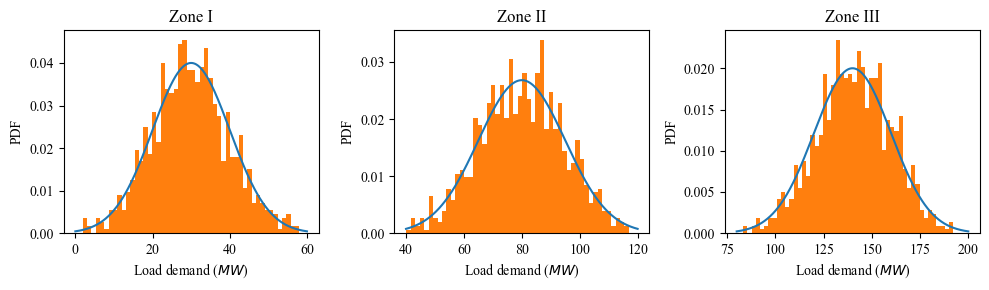

In [220]:
# Plot normal PDF
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(131)
ax1.plot(lx1, tn_pdf1)
counts, bins, _ = ax1.hist(tn_rv1, bins=50, density=True)
ax1.set_xlabel('Load demand ($MW$)')
ax1.set_ylabel('PDF')
ax1.set_title('Zone I')

ax2 = fig.add_subplot(132)
ax2.plot(lx2, tn_pdf2)
counts, bins, _ = ax2.hist(tn_rv2, bins=50, density=True)
ax2.set_xlabel('Load demand ($MW$)')
ax2.set_ylabel('PDF')
ax2.set_title('Zone II')

ax3 = fig.add_subplot(133)
ax3.plot(lx3, tn_pdf3)
counts, bins, _ = ax3.hist(tn_rv3, bins=50, density=True)
ax3.set_xlabel('Load demand ($MW$)')
ax3.set_ylabel('PDF')
ax3.set_title('Zone III')

plt.tight_layout()
plt.show()
plt.close('all')

In [221]:
## Define func wind speed --> wind energy
def wind_P(w):
    """
        input:
            w: wind speed (m/s), ndarray
        output:
            P: wind power (MW), ndarray
    """
    # Check the input type
    if type(w) != np.ndarray:
        raise TypeError("'w' should be 'numpy.ndarray'.")
    # Define output array
    P = np.zeros(len(w))
    # Set maximum allowed wind power generation
    Pr = 200.
    # No wind power if w < wi
    wi = 0.5
    # Wind speed that reaches maximum allowed wind power capacity
    wr = 15.
    # Convert wind speed to wind power
    P = Pr*(w**3 - wi**3)/(wr**3 - wi**3)
    # Get index of wind speed less than wi
    left_index = (w < wi)
    P[left_index] = 0.
    # Get index of wind speed bigger than wi
    right_index = (w > wr)
    P[right_index] = Pr

    return P

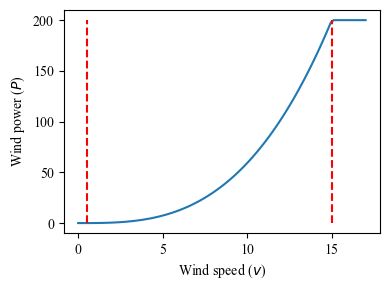

In [222]:
w = np.linspace(0, 17, 100)
P = wind_P(w)
plt.plot(w, P)
plt.vlines(x=0.5, ymin=0, ymax = 200, color='red', linestyles='dashed')
plt.vlines(x=15., ymin=0, ymax = 200, color='red', linestyles='dashed')
plt.xlabel('Wind speed ($v$)')
plt.ylabel('Wind power ($P$)')
plt.tight_layout()
plt.show()
plt.close('all')

#### Zone I - Wind

In [223]:
## Truncated Weibull distribution for Wind
# Shape parameter
shape1 = 2
# Scale parameter
scale1 = 7
# Location parameter
loc1 = 0
# Left truncation
rv_min1 = 0
# Right truncation
rv_max1 = 18
# Left truncation parameter
left_trunc1 = (rv_min1 - loc1)/scale1
# Right trunction parameter
right_trunc1 = (rv_max1 - loc1)/scale1
# Number of random variables
rv_num1 = 1000
# Generate grid
lx1 = np.linspace(rv_min1, rv_max1, rv_num1)
# Generate truncated Weibull RV
twb1 = stats.weibull_min(c=shape1, 
                         loc=loc1, 
                         scale=scale1)
twb_rv1 = twb1.rvs(size=rv_num1)
# Generat truncatd Weibull PDF
twb_pdf1 = twb1.pdf(x=lx1)

# Calculate wind energy (Assuming Power = cube of speed)
wind_power1 = wind_P(twb_rv1)

#### Zone II - Wind

In [224]:
## Truncated Weibull distribution for Wind
# Shape parameter
shape2 = 2.5
# Scale parameter
scale2 = 7
# Location parameter
loc2 = 0.5
# Left truncation
rv_min2 = 0
# Right truncation
rv_max2 = 15
# Left truncation parameter
left_trunc2 = (rv_min2 - loc2)/scale2
# Right trunction parameter
right_trunc2 = (rv_max2 - loc2)/scale2
# Number of random variables
rv_num2 = 1000
# Generate grid
lx2 = np.linspace(rv_min2, rv_max2, rv_num2)
# Generate truncated Weibull RV
twb2 = stats.weibull_min(c=shape2, 
                         loc=loc2, 
                         scale=scale2)
twb_rv2 = twb2.rvs(size=rv_num2)
# Generat truncatd Weibull PDF
twb_pdf2 = twb2.pdf(x=lx2)

# Calculate wind energy (Assuming Power = cube of speed)
wind_power2 = wind_P(twb_rv2)

#### Zone III - Wind

In [225]:
## Truncated Weibull distribution for Wind
# Shape parameter
shape3 = 3
# Scale parameter
scale3 = 6
# Location parameter
loc3 = 1
# Left truncation
rv_min3 = 0
# Right truncation
rv_max3 = 16
# Left truncation parameter
left_trunc3 = (rv_min3 - loc3)/scale3
# Right trunction parameter
right_trunc3 = (rv_max3 - loc3)/scale3
# Number of random variables
rv_num3 = 1000
# Generate grid
lx3 = np.linspace(rv_min3, rv_max3, rv_num3)
# Generate truncated Weibull RV
twb3 = stats.weibull_min(c=shape3, 
                         loc=loc3, 
                         scale=scale3)
twb_rv3 = twb3.rvs(size=rv_num3)
# Generat truncatd Weibull PDF
twb_pdf3 = twb3.pdf(x=lx3)

# Calculate wind energy (Assuming Power = cube of speed)
wind_power3 = wind_P(twb_rv3)

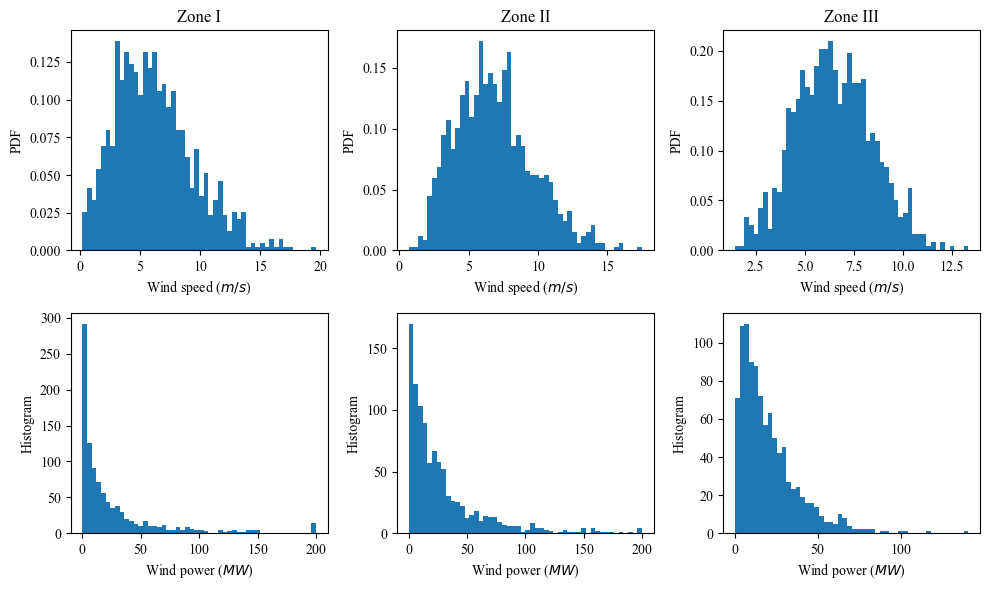

In [226]:
# Plot normal PDF
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(231)
# ax1.plot(lx1, twb_pdf1)
counts, bins, _ = ax1.hist(twb_rv1, bins=50, density=True)
ax1.set_xlabel('Wind speed ($m/s$)')
ax1.set_ylabel('PDF')
ax1.set_title('Zone I')

ax2 = fig.add_subplot(232)
# ax2.plot(lx2, twb_pdf2)
counts, bins, _ = ax2.hist(twb_rv2, bins=50, density=True)
ax2.set_xlabel('Wind speed ($m/s$)')
ax2.set_ylabel('PDF')
ax2.set_title('Zone II')

ax3 = fig.add_subplot(233)
# ax3.plot(lx3, twb_pdf3)
counts, bins, _ = ax3.hist(twb_rv3, bins=50, density=True)
ax3.set_xlabel('Wind speed ($m/s$)')
ax3.set_ylabel('PDF')
ax3.set_title('Zone III')

ax4 = fig.add_subplot(234)
counts, bins, _ = ax4.hist(wind_power1, bins=50)
ax4.set_xlabel('Wind power ($MW$)')
ax4.set_ylabel('Histogram')

ax5 = fig.add_subplot(235)
counts, bins, _ = ax5.hist(wind_power2, bins=50)
ax5.set_xlabel('Wind power ($MW$)')
ax5.set_ylabel('Histogram')

ax6 = fig.add_subplot(236)
counts, bins, _ = ax6.hist(wind_power3, bins=50)
ax6.set_xlabel('Wind power ($MW$)')
ax6.set_ylabel('Histogram')


plt.tight_layout()
plt.show()
plt.close('all')

In [227]:
## The correlation matrix is tentatively determined as:
corr_mat = np.array([[1., 0.7, 0.5, 0.1, 0.05, 0.03],
                     [0.7, 1., 0.4, 0.02, 0.08, 0.05],
                     [0.5, 0.4, 1., 0.06, 0.04, 0.1],
                     [0.1, 0.02, 0.06, 1., 0.3, 0.4],
                     [0.05, 0.08, 0.04, 0.3, 1., 0.6],
                     [0.03, 0.05, 0.1, 0.4, 0.6, 1.]])

## Set proportions (Only two aggregated random variables will be generated for each zone, i.e., load and wind, 
## the rest will be calculated via the preset proportion sequence)
# Get the number of load and RES buses in each zone
L1_num, L2_num, L3_num = 29, 38, 32
R1_num, R2_num, R3_num = 3, 7, 6

# Set the proportion between loads
np.random.seed(10)
L1_P = np.random.uniform(0.5, 1.4, size=L1_num)
np.random.seed(10)
L2_P = np.random.uniform(0.5, 1.4, size=L2_num)
np.random.seed(10)
L3_P = np.random.uniform(0.5, 1.4, size=L3_num)

# Set the proportion between RES
np.random.seed(10)
R1_P = np.random.uniform(0.5, 1., size=R1_num)
np.random.seed(10)
R2_P = np.random.uniform(0.5, 1., size=R2_num)
np.random.seed(10)
R3_P = np.random.uniform(0.5, 1., size=R3_num)

# Reset random seed
np.random.seed()

#### Generate synthetic data

In [228]:
## Number of OPF solutions
num = 1000

## Generate correlated random variables
# Generate multivariate normal PDF (In case of standard normal PDF: covariance = correlation)
mvnorm = stats.multivariate_normal(cov=corr_mat)
mvnorm_rv = mvnorm.rvs(size=num)
# Get corresponding CDF
rv_cdf = stats.norm.cdf(mvnorm_rv)
# Generate RV under target PDFs using inverse CDF
L1_ref = tn1.ppf(rv_cdf[:, 0])
L2_ref = tn2.ppf(rv_cdf[:, 1])
L3_ref = tn3.ppf(rv_cdf[:, 2])
R1_ref = wind_P(twb1.ppf(rv_cdf[:, 3]))
R2_ref = wind_P(twb2.ppf(rv_cdf[:, 4]))
R3_ref = wind_P(twb3.ppf(rv_cdf[:, 5]))

while True:
    # Generate values for the rest of loads and RES
    L1 = L1_P*L1_ref[lp_line_list.shape[1]-1]
    L2 = L2_P*L2_ref[lp_line_list.shape[1]-1]
    L3 = L3_P*L3_ref[lp_line_list.shape[1]-1]
    R1 = R1_P*R1_ref[lp_line_list.shape[1]-1]
    R2 = R2_P*R2_ref[lp_line_list.shape[1]-1]
    R3 = R3_P*R3_ref[lp_line_list.shape[1]-1]

    ## Set p_mw at load buses
    net.load.p_mw[np.isin(net.load.bus, area1_load_bus)] = L1
    net.load.p_mw[np.isin(net.load.bus, area2_load_bus)] = L2
    net.load.p_mw[np.isin(net.load.bus, area3_load_bus)] = L3

    ## Set max_p_mw and min_p_mw at re_gen buses
    net.gen.max_p_mw[np.isin(net.gen.bus, area1_re_gen_bus)] = R1
    net.gen.min_p_mw[np.isin(net.gen.bus, area1_re_gen_bus)] = R1
    net.gen.max_p_mw[np.isin(net.gen.bus, area2_re_gen_bus)] = R2
    net.gen.min_p_mw[np.isin(net.gen.bus, area2_re_gen_bus)] = R2
    net.gen.max_p_mw[np.isin(net.gen.bus, area3_re_gen_bus)] = R3
    net.gen.min_p_mw[np.isin(net.gen.bus, area3_re_gen_bus)] = R3

    # Set 'max_p_mw' at slack bus at alpha*(the sum of max_p_mw at generator)
    if net.load.p_mw.sum() >= net.gen.max_p_mw.sum():
        net.ext_grid.max_p_mw = net.load.p_mw.sum() - net.gen.max_p_mw.sum()
    else:
        net.ext_grid.max_p_mw = 0.

    ## Run OPF solver (ignore errors) and collect data
    try:
        ## Run DCOPP
        pp.rundcopp(net)

        ## Collect data
        # p_mw at load buses
        p_load = net.load.p_mw.to_numpy().reshape((-1, 1))
        p_load_list = np.concatenate([p_load_list, p_load], axis=1)
        # max_p_mw at gen buses
        p_max_gen = net.gen.max_p_mw.to_numpy().reshape((-1, 1))
        p_max_gen_list = np.concatenate([p_max_gen_list, p_max_gen], axis=1)
        # max_p_mw at slack bus
        p_slack_max_list.append(net.ext_grid.max_p_mw.values)

        ## Collect results
        # Results of p_mw at all buses
        # order='F' means first index changes fastest while last index changes slowest
        p_bus = net.res_bus[bus_features].to_numpy().reshape((-1, len(bus_features)), order='F') 
        p_bus_list = np.concatenate([p_bus_list, p_bus], axis=1)
        # Results of p_mw at gen buses
        p_gen = net.res_gen[gen_features].to_numpy().reshape((-1, 1), order='F')  
        p_gen_list = np.concatenate([p_gen_list, p_gen], axis=1)
        # Results of power flow at all lines
        pf_line = net.res_line[line_features].to_numpy().reshape((-1, 1), order='F')
        pf_line_list = np.concatenate([pf_line_list, pf_line], axis=1)
        # Results of loading percent at all lines
        lp_line = net.res_line.loading_percent.to_numpy().reshape((-1, 1))
        lp_line_list = np.concatenate([lp_line_list, lp_line], axis=1)
        # Results of shedding and reserve
        shedding_reserve = net.load.p_mw.sum() - net.gen.max_p_mw.sum()
        shedding_reserve_list.append(shedding_reserve)
        # Results of total cost
        total_cost = net.res_cost/1e3
        total_cost_list.append(total_cost)
    except:
        pass

    ## Make sure the target amount of synthetic data is obtained
    if lp_line_list.shape[1] == num+1:
        break
    else:
        pass

#### Save synthetic data

In [229]:
# Save synthetic data (node level)
pd.DataFrame(p_load_list[:, 1:]).to_csv('synthetic_data/p_load_data.csv')
pd.DataFrame(p_max_gen_list[:, 1:]).to_csv('synthetic_data/p_max_gen_data.csv')
pd.DataFrame(p_slack_max_list).to_csv('synthetic_data/p_slack_max_data.csv')
pd.DataFrame(p_bus_list[:, len(bus_features):]).to_csv('synthetic_data/p_bus_data.csv')
pd.DataFrame(p_gen_list[:, 1:]).to_csv('synthetic_data/p_gen_data.csv')

# Save synthetic data (edge level)
pd.DataFrame(pf_line_list[:, 1:]).to_csv('synthetic_data/pf_line_data.csv')
pd.DataFrame(lp_line_list[:, 1:]).to_csv('synthetic_data/lp_line_data.csv')

pd.DataFrame(lp_line_list[:, 1:]).to_csv('reliability_risk/lp_true_corr.csv')

# Save synthetic data (graph level)
graph_features = pd.concat([pd.Series(shedding_reserve_list, name='shedding_reserve'), 
                           pd.Series(total_cost_list, name='total_cost(10^3)')], 
                           axis=1)
graph_features.T.to_csv('synthetic_data/graph_features.csv')

In [230]:
# Save gen, load bus no
pd.Series(re_gen_bus).to_csv('synthetic_data/re_gen_bus.csv')
pd.Series(re_gen_no.astype(float)).to_csv('synthetic_data/re_gen_no.csv')
pd.Series(gen_no.astype(float)).to_csv('synthetic_data/gen_no.csv')
pd.Series(load_no.astype(float)).to_csv('synthetic_data/load_no.csv')